<h1 style="font-size:3rem;color:orange;">Eleições 2022 - Análise dos Votos Para Presidente</h1>

AVISO de Licença de Uso e Reserva de Direitos Autorais BSD 3 Clause. Copyright (c) 2022 por John Robson <john.robson@msn.com> (PIX)

Todo o Código fonte e demais arquivos estão sobre a Licença BSD 3 Clause. Modificações, Redistribuição, uso Comercial são permitidos, sempre informando
esse aviso de direitos autorais e o repositório oficial: https://github.com/JohnRobson/Eleicoes2022

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:0,.2f}'.format

import timeit
import ast
from sqlalchemy import select, func

import ipympl
import matplotlib.pylab as plt
# %matplotlib inline
%matplotlib widget

from IPython.display import Markdown, display, HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
display(HTML("<style>div.output_scroll { height: 100%; }</style>"))

from bd_urnas import engine, Base, Session, Urnas
from src_config import federacao, estados_federacao
session = Session()

def printmd(string): # convert markdown para HTML
    display(Markdown(string))

In [3]:
# Importando Banco de Dados para Python Pandas Dataframe
bd = pd.read_sql_query('SELECT id, turno, regiao, estado, municipio, zona, local, secao, vPresA22, vPresB13, vPresC15, vPresD12, vPresNulo, vPresBranco, qEleitAptos, qComparecimento, modelUrna FROM urnas', session.bind)

# Criação de Colunas Extas para Análises
bd['vPresBN'] = bd['vPresBranco'] + bd['vPresNulo'] # presidente votos Nulos e Brancos
bd['vPresOutros'] = bd['qComparecimento'].sub(bd['vPresA22'] + bd['vPresB13'] + bd['vPresC15'] + bd['vPresD12'] + bd['vPresBN']) # coluna total votos governado

In [4]:
def modelos_pais(turno=1):
  bdt = bd[bd['turno'] == turno]
  # conta a quantidade de urnas de cada modelo
  modelos_urna = bdt.groupby(['modelUrna'])['modelUrna'].count().rename('qtd Urnas', inplace=True)
  # modelos_urna.drop(['UE0000', 'UE1111'], inplace=True) # remove modelos não informados
  # conta o total de votos recebido em cada modelo
  if turno == 1: total_votos_modelo = bdt.groupby('modelUrna')[['qComparecimento', 'vPresA22', 'vPresB13', 'vPresC15', 'vPresD12', 'vPresOutros', 'vPresBN']].sum()
  else: total_votos_modelo = bdt.groupby('modelUrna')[['qComparecimento', 'vPresA22', 'vPresB13', 'vPresBN']].sum()
  # total_votos_modelo.drop(['UE0000', 'UE1111'], inplace=True) # remove modelos não informados
  total_votos_modelo.rename(columns={'qComparecimento': 'Votos Totais', 'vPresA22': 'Votos Bolsonaro', 'vPresB13': 'Votos Lula', 'vPresC15': 'Votos Simone', 'vPresD12': 'Votos Ciro', 'vPresOutros': 'Votos Outros', 'vPresBN': 'Votos BN'}, inplace=True) # renomeia as colunas
  # calcula o percentual de votos que cada modelo de urna recebeu no país
  perc_votos_modelo = total_votos_modelo['Votos Totais'].div(total_votos_modelo['Votos Totais'].sum()).multiply(100).round(2).rename('% Votos Totais', inplace=True)
  
  tabela_modelos_urna = pd.concat([modelos_urna, perc_votos_modelo, total_votos_modelo], axis=1)
  # tabela_modelos_urna.rename(columns={'qComparecimento': 'Votos Totais'}, inplace=True) # renomeia as colunas
  tabela_grupos_urna = tabela_modelos_urna.copy()
  
   # calcula a soma de cada coluna
  tabela_modelos_urna.loc['TOTAL'] = tabela_modelos_urna.sum(axis=0)
  
  # calcula o percentual de votos de cada presidente de acoardo com o model de urna
  tabela_modelos_urna['% Bolsonaro'] = tabela_modelos_urna['Votos Bolsonaro'].div(tabela_modelos_urna['Votos Totais']).multiply(100).round(2)
  tabela_modelos_urna['% Lula'] = tabela_modelos_urna['Votos Lula'].div(tabela_modelos_urna['Votos Totais']).multiply(100).round(2)
  if turno == 1:
    tabela_modelos_urna['% Simone'] = tabela_modelos_urna['Votos Simone'].div(tabela_modelos_urna['Votos Totais']).multiply(100).round(2)
    tabela_modelos_urna['% Ciro'] = tabela_modelos_urna['Votos Ciro'].div(tabela_modelos_urna['Votos Totais']).multiply(100).round(2)
    tabela_modelos_urna['% Outros'] = tabela_modelos_urna['Votos Outros'].div(tabela_modelos_urna['Votos Totais']).multiply(100).round(2)
  tabela_modelos_urna['% BrancoNulo'] = tabela_modelos_urna['Votos BN'].div(tabela_modelos_urna['Votos Totais']).multiply(100).round(2)
  
  # retira decimal dos números inteiros
  tabela_modelos_urna['qtd Urnas'] = tabela_modelos_urna['qtd Urnas'].map('{:,.0f}'.format)
  tabela_modelos_urna['Votos Totais'] = tabela_modelos_urna['Votos Totais'].map('{:,.0f}'.format)
  tabela_modelos_urna['Votos Bolsonaro'] = tabela_modelos_urna['Votos Bolsonaro'].map('{:,.0f}'.format)
  tabela_modelos_urna['Votos Lula'] = tabela_modelos_urna['Votos Lula'].map('{:,.0f}'.format)
  tabela_modelos_urna['Votos BN'] = tabela_modelos_urna['Votos BN'].map('{:,.0f}'.format)
  
  if turno == 1:
    tabela_modelos_urna['Votos Simone'] = tabela_modelos_urna['Votos Simone'].map('{:,.0f}'.format)
    tabela_modelos_urna['Votos Ciro'] = tabela_modelos_urna['Votos Ciro'].map('{:,.0f}'.format)
    tabela_modelos_urna['Votos Outros'] = tabela_modelos_urna['Votos Outros'].map('{:,.0f}'.format) 

  # Grupo de Urnas
  tabela_grupos_urna.loc['NÃO-UE2020'] = tabela_grupos_urna.drop('UE2020').sum(axis=0)
  tabela_grupos_urna = tabela_grupos_urna.tail(2) # mantém as 2 últimas linhas "UE2020" e "NÃO-UE20202"
  tabela_grupos_urna = tabela_grupos_urna.iloc[::-1] # flipa as linhas
  tabela_grupos_urna.loc['TOTAL'] = tabela_grupos_urna.sum(axis=0)
 
  # calcula o percentual de votos de cada presidente de acoardo com o grupo de modelo de urna
  tabela_grupos_urna['% Bolsonaro'] = tabela_grupos_urna['Votos Bolsonaro'].div(tabela_grupos_urna['Votos Totais']).multiply(100).round(2)
  tabela_grupos_urna['% Lula'] = tabela_grupos_urna['Votos Lula'].div(tabela_grupos_urna['Votos Totais']).multiply(100).round(2)
  if turno == 1:
    tabela_grupos_urna['% Simone'] = tabela_grupos_urna['Votos Simone'].div(tabela_grupos_urna['Votos Totais']).multiply(100).round(2)
    tabela_grupos_urna['% Ciro'] = tabela_grupos_urna['Votos Ciro'].div(tabela_grupos_urna['Votos Totais']).multiply(100).round(2)
    tabela_grupos_urna['% Outros'] = tabela_grupos_urna['Votos Outros'].div(tabela_grupos_urna['Votos Totais']).multiply(100).round(2)
  tabela_grupos_urna['% BrancoNulo'] = tabela_grupos_urna['Votos BN'].div(tabela_grupos_urna['Votos Totais']).multiply(100).round(2)
  
  # calcula a diferença percentual entre as urnas "NÃO-UE2020" e as "UE2020"
  tabela_grupos_urna.loc['DIFERENÇA %'] = tabela_grupos_urna.loc['NÃO-UE2020'].div(tabela_grupos_urna.loc['UE2020']).sub(1).multiply(100).round(2)
  # limpa as primeiras colunas da linha "Diferença %"
  if turno == 1: tabela_grupos_urna.loc['DIFERENÇA %'][0:9] = np.nan
  else: tabela_grupos_urna.loc['DIFERENÇA %'][0:6] = np.nan
  
  tabela_grupos_urna['qtd Urnas'] = tabela_grupos_urna['qtd Urnas'].map('{:,.0f}'.format)
  tabela_grupos_urna['Votos Totais'] = tabela_grupos_urna['Votos Totais'].map('{:,.0f}'.format)
  tabela_grupos_urna['Votos Bolsonaro'] = tabela_grupos_urna['Votos Bolsonaro'].map('{:,.0f}'.format)
  tabela_grupos_urna['Votos Lula'] = tabela_grupos_urna['Votos Lula'].map('{:,.0f}'.format)
  tabela_grupos_urna['Votos BN'] = tabela_grupos_urna['Votos BN'].map('{:,.0f}'.format)
  if turno == 1:
    tabela_grupos_urna['Votos Simone'] = tabela_grupos_urna['Votos Simone'].map('{:,.0f}'.format)
    tabela_grupos_urna['Votos Ciro'] = tabela_grupos_urna['Votos Ciro'].map('{:,.0f}'.format)
    tabela_grupos_urna['Votos Outros'] = tabela_grupos_urna['Votos Outros'].map('{:,.0f}'.format) 

  # substitui NaN por vazio
  tabela_grupos_urna.replace(np.nan, '', regex=True, inplace=True); tabela_grupos_urna.replace(str(np.nan), '', regex=True, inplace=True) # substitui NaN por vazio

  return tabela_modelos_urna, tabela_grupos_urna

### Relação dos Modelos de Urnas Usadas nas Eleições 2022, quantidade de Votos Válidos por modelo e Percentual de Votos Recebido por cada Candidato a Presidente:

A Tabela 1 mostra a distribuição do percentual de votos recebidos em cada modelo de urna e para cada candidato a presidência. Nas eleições de 2022 foram utilizados 6 modelos de urnas e os dados do TSE não permitiram identicar 2 modelos de urna que representam menos de 0.02% dos votos, portanto serão desconsiderados na análise da distribuição dos modelos.

Tabela 2 mostra o Modelo "UE2020" e o agrupamento dos modelos anteriores com o nome de "Não-UE2020"

obs: Foram listados apenas os primeiros 4 melhores colocados na votação de primeiro turno, pois todos os demais candidatos tiveram menos votos que Brancos e Nulos.

obs: Os códigos "UE0000" (BUs Sem Log da urna) e "UE1111" (BUs Com Log da urna, mas que não informa o modelo), serão desconsiderados nos próximos cálculos.

#### Análise da Distribuição dos Votos no 1° Turno de Acordo com o Modelo de Urna

In [5]:
tabela_modelos_urna, tabela_grupos_urna = modelos_pais(turno=1)

printmd('Na Tabela 1 vemos que todos os candidatos (incluindo Outros e Brancos/Nulos) receberam, de forma bem distribuída, votos de todos os modelos de urnas, portanto não há concentração de votos oriundos de apenas um único modelo de urna.')

tabela_modelos_urna

printmd('Na Tabela 1 também percebemos que, por alguma razão, **com a exceção do candidato Lula**, todos os demais candidatos (incluindo Outros e Brancos/Nulos) **reberam menos votos dos modelos de urna Anteriores ao modelo "UE2020"**.')

tabela_grupos_urna

printmd('Na Tabela 2, todas as urnas anteriores ao modelo "UE2020" foram agrupadas em um grupo chamado "NÃO-UE2020" que recebeu quase 57% dos votos nas Eleições 2022. Os dados mostram que **com a exceção do candidato Lula**, todos os demais receberam menos votos nesse **modelo antigo de urna**. A Tabela 2 também apresenta a Diferença Percentual de votos recebidas no modelo "NÃO-UE2020", que foi quase **10% favorável para o candidato Lula**, e desfavorável em -5.5% para Bolsonaro, sendo que os demais canditados, Simone, Ciro e Outros, tudos obtiveram praticamente o mesmo valor de -20% dos votos. Os votos Brancos/Nulos também foram -2.90 menores nessas urnas.')

printmd('Ou seja, **os modelos antigos de urnas "NÃO-UE2020" (de 2009 até 2015, época do governo PT), apresentaram uma vantagem de 19.45% para o candidato Lula em Relação ao canditado Bolsonaro. Enquanto os modelos atuais e auditados "UE-2020" apresentaram uma vantagem 3% do Lula contra Bolsonaro**.')

Na Tabela 1 vemos que todos os candidatos (incluindo Outros e Brancos/Nulos) receberam, de forma bem distribuída, votos de todos os modelos de urnas, portanto não há concentração de votos oriundos de apenas um único modelo de urna.

,qtd Urnas,% Votos Totais,Votos Totais,Votos Bolsonaro,Votos Lula,Votos Simone,Votos Ciro,Votos Outros,Votos BN,% Bolsonaro,% Lula,% Simone,% Ciro,% Outros,% BrancoNulo
modelUrna,,,,,,,,,,,,,,,
UE0000,57,0.02,"19,423","5,836","11,626",509,718,245,489,30.05,59.86,2.62,3.70,1.26,2.52
UE1111,10,0.00,"2,692",955,"1,407",102,90,21,117,35.48,52.27,3.79,3.34,0.78,4.35
UE2009,"46,636",9.47,"11,710,715","4,854,836","5,515,362","405,614","321,521","119,220","494,162",41.46,47.10,3.46,2.75,1.02,4.22
UE2010,"94,365",19.02,"23,521,476","9,209,857","11,622,458","822,118","609,726","234,068","1,023,249",39.16,49.41,3.50,2.59,1.00,4.35
UE2011,"27,536",5.51,"6,811,846","2,656,740","3,346,511","246,282","187,638","68,434","306,241",39.00,49.13,3.62,2.75,1.00,4.50
UE2013,"24,986",5.00,"6,185,168","2,577,434","2,920,183","214,174","154,499","58,488","260,390",41.67,47.21,3.46,2.50,0.95,4.21
UE2015,"85,794",17.67,"21,860,566","8,940,299","10,321,716","833,392","571,836","225,575","967,748",40.90,47.22,3.81,2.62,1.03,4.43
UE2020,"192,640",43.31,"53,570,481","22,826,388","23,520,241","2,393,232","1,753,259","677,109","2,400,252",42.61,43.91,4.47,3.27,1.26,4.48
TOTAL,"472,024",100.00,"123,682,367","51,072,345","57,259,504","4,915,423","3,599,287","1,383,160","5,452,648",41.29,46.30,3.97,2.91,1.12,4.41


Na Tabela 1 também percebemos que, por alguma razão, **com a exceção do candidato Lula**, todos os demais candidatos (incluindo Outros e Brancos/Nulos) **reberam menos votos dos modelos de urna Anteriores ao modelo "UE2020"**.

,qtd Urnas,% Votos Totais,Votos Totais,Votos Bolsonaro,Votos Lula,Votos Simone,Votos Ciro,Votos Outros,Votos BN,% Bolsonaro,% Lula,% Simone,% Ciro,% Outros,% BrancoNulo
modelUrna,,,,,,,,,,,,,,,
NÃO-UE2020,"279,384",56.69,"70,111,886","28,245,957","33,739,263","2,522,191","1,846,028","706,051","3,052,396",40.29,48.12,3.60,2.63,1.01,4.35
UE2020,"192,640",43.31,"53,570,481","22,826,388","23,520,241","2,393,232","1,753,259","677,109","2,400,252",42.61,43.91,4.47,3.27,1.26,4.48
TOTAL,"472,024",100.00,"123,682,367","51,072,345","57,259,504","4,915,423","3,599,287","1,383,160","5,452,648",41.29,46.30,3.97,2.91,1.12,4.41
DIFERENÇA %,,,,,,,,,,-5.44,9.59,-19.46,-19.57,-19.84,-2.90


Na Tabela 2, todas as urnas anteriores ao modelo "UE2020" foram agrupadas em um grupo chamado "NÃO-UE2020" que recebeu quase 57% dos votos nas Eleições 2022. Os dados mostram que **com a exceção do candidato Lula**, todos os demais receberam menos votos nesse **modelo antigo de urna**. A Tabela 2 também apresenta a Diferença Percentual de votos recebidas no modelo "NÃO-UE2020", que foi quase **10% favorável para o candidato Lula**, e desfavorável em -5.5% para Bolsonaro, sendo que os demais canditados, Simone, Ciro e Outros, tudos obtiveram praticamente o mesmo valor de -20% dos votos. Os votos Brancos/Nulos também foram -2.90 menores nessas urnas.

Ou seja, **os modelos antigos de urnas "NÃO-UE2020" (de 2009 até 2015, época do governo PT), apresentaram uma vantagem de 19.45% para o candidato Lula em Relação ao canditado Bolsonaro. Enquanto os modelos atuais e auditados "UE-2020" apresentaram uma vantagem 3% do Lula contra Bolsonaro**.

#### Análise da Distribuição dos Votos no 2° Turno de Acordo com o Modelo de Urna

In [6]:
tabela_modelos_urna, tabela_grupos_urna = modelos_pais(turno=2)

printmd('Na Tabela 1 continua presente a relação de maior percentual de votos para o candidato Lula nas urnas antigas "NÃO-UE2020".')

tabela_modelos_urna

printmd('Na Tabela 2, as urnas antigas "NÃO-UE2020" mostram uma vantagem de 50% dos votos para Lula e 45.5% dos votos para Bolsonaro, enquanto as urnas novas,  "UE2020" mostram um resultado de 48.63% para Bolsonaro e 46.63% para Lula, ou seja, 2 pontos percentuais correspondendo a 1.078.171 votos.')

tabela_grupos_urna

printmd('O grupo de urnas antigas "NÃO-UE-2020", apresentaram uma vantagem de 10.05% para o candidato Lula em Relação ao canditado Bolsonaro. Enquanto os modelos atuais e auditados "UE-2020" apresentaram uma vantagem 4.29% para o candidato Bolsonaro em reação ao Lula**.')

Na Tabela 1 continua presente a relação de maior percentual de votos para o candidato Lula nas urnas antigas "NÃO-UE2020".

,qtd Urnas,% Votos Totais,Votos Totais,Votos Bolsonaro,Votos Lula,Votos BN,% Bolsonaro,% Lula,% BrancoNulo
modelUrna,,,,,,,,,
UE0000,5,0.00,"1,071",221,836,14,20.63,78.06,1.31
UE2009,"48,245",9.82,"12,203,589","5,722,673","5,963,741","517,175",46.89,48.87,4.24
UE2010,"93,790",18.92,"23,508,155","10,379,046","12,069,548","1,059,561",44.15,51.34,4.51
UE2011,"26,889",5.38,"6,679,909","2,943,287","3,432,852","303,770",44.06,51.39,4.55
UE2013,"24,672",4.93,"6,128,515","2,857,302","3,001,068","270,145",46.62,48.97,4.41
UE2015,"85,735",17.61,"21,880,318","10,114,104","10,766,404","999,810",46.22,49.21,4.57
UE2020,"192,691",43.34,"53,851,239","26,189,721","25,111,550","2,549,968",48.63,46.63,4.74
TOTAL,"472,027",100.00,"124,252,796","58,206,354","60,345,999","5,700,443",46.85,48.57,4.59


Na Tabela 2, as urnas antigas "NÃO-UE2020" mostram uma vantagem de 50% dos votos para Lula e 45.5% dos votos para Bolsonaro, enquanto as urnas novas,  "UE2020" mostram um resultado de 48.63% para Bolsonaro e 46.63% para Lula, ou seja, 2 pontos percentuais correspondendo a 1.078.171 votos.

,qtd Urnas,% Votos Totais,Votos Totais,Votos Bolsonaro,Votos Lula,Votos BN,% Bolsonaro,% Lula,% BrancoNulo
modelUrna,,,,,,,,,
NÃO-UE2020,"279,336",56.66,"70,401,557","32,016,633","35,234,449","3,150,475",45.48,50.05,4.48
UE2020,"192,691",43.34,"53,851,239","26,189,721","25,111,550","2,549,968",48.63,46.63,4.74
TOTAL,"472,027",100.00,"124,252,796","58,206,354","60,345,999","5,700,443",46.85,48.57,4.59
DIFERENÇA %,,,,,,,-6.48,7.33,-5.49


O grupo de urnas antigas "NÃO-UE-2020", apresentaram uma vantagem de 10.05% para o candidato Lula em Relação ao canditado Bolsonaro. Enquanto os modelos atuais e auditados "UE-2020" apresentaram uma vantagem 4.29% para o candidato Bolsonaro em reação ao Lula**.

In [7]:
bd = bd.drop(bd[bd['modelUrna'] == 'UE0000'].index) # remove as urnas sem identificação de modelo (57 no 1o turno e 5 no 2o turno)
bd = bd.drop(bd[bd['modelUrna'] == 'UE1111'].index) # remove as urnas sem identificação de modelo (10 no 1o turno e 0 no 2o turno)

### Analisando a distribuição de cada modelo de urna pelas Regiões do Brasil

In [97]:
# para cada região do país, conta o número de urnas
bdt = bd[bd['turno'] == 2]
modelos_urna = bdt.groupby(['regiao', 'modelUrna'])['modelUrna'].count().reset_index(name='qtd')
modelos_urna = modelos_urna.pivot(index='regiao', columns='modelUrna', values='qtd').fillna(0).astype(int) # reorganiza tabela

total_urnas = modelos_urna.sum(axis=1) # calcula o total de urnas para cada região
modelos_urna_pct = modelos_urna.div(total_urnas, axis=0).multiply(100).round(2)
modelos_urna['TOTAL'] = modelos_urna.sum(axis=1)

modelos_urna_pct_UE2020 = modelos_urna_pct.pop('UE2020') # temporatiamente remove o modelo "UE2020"
modelos_urna_pct['NÃO-UE2020'] = modelos_urna_pct.iloc[:, 0:5].sum(axis=1) # cria coluna "NÃO-UE2020"
modelos_urna_pct = pd.concat([modelos_urna_pct, modelos_urna_pct_UE2020], axis=1) # reinsere o modelo "UE2020"

tabela_modelos_regiao = pd.concat([modelos_urna, modelos_urna_pct], axis=1)

printmd('A primeira parte da tabela abaixo mostra a quantidade de cada modelo de urna por Região, em seguida a coluna "TOTAL" mostra o total de urnas usadas na região e a segunda parte da tabela mostra os percentuais de cada modelo de urna em relação ao total da região.')

tabela_modelos_regiao

printmd('A princípio percebe-se que todos os modelos de urna tem a mesma Distribuição Percentual em todas regiões, com exceção da região "EX" (exterior), onde a maior parte é do modelo UE2009 e todas são "NÃO-UE2020". Como formam um pequeno número de urnas, vamos temporariamente remover essa região (e seu "estado" "ZZ") e calcular a média de cada modelo usado no país.')

A primeira parte da tabela abaixo mostra a quantidade de cada modelo de urna por Região, em seguida a coluna "TOTAL" mostra o total de urnas usadas na região e a segunda parte da tabela mostra os percentuais de cada modelo de urna em relação ao total da região.

,UE2009,UE2010,UE2011,UE2013,UE2015,UE2020,TOTAL,UE2009,UE2010,UE2011,UE2013,UE2015,NÃO-UE2020,UE2020
regiao,,,,,,,,,,,,,,
CO,3966,5933,1401,2097,6019,16516,35932,11.04,16.51,3.90,5.84,16.75,54.04,45.96
EX,833,69,0,0,115,0,1017,81.91,6.78,0.00,0.00,11.31,100.00,0.00
N,3668,7305,2330,1986,6765,16916,38970,9.41,18.75,5.98,5.10,17.36,56.60,43.41
NE,13746,27236,8041,7418,21740,54397,132578,10.37,20.54,6.07,5.60,16.40,58.98,41.03
S,5974,14373,3459,5163,12301,27894,69164,8.64,20.78,5.00,7.46,17.79,59.67,40.33
SE,20058,38874,11658,8008,38795,76968,194361,10.32,20.00,6.00,4.12,19.96,60.40,39.60


A princípio percebe-se que todos os modelos de urna tem a mesma Distribuição Percentual em todas regiões, com exceção da região "EX" (exterior), onde a maior parte é do modelo UE2009 e todas são "NÃO-UE2020". Como formam um pequeno número de urnas, vamos temporariamente remover essa região (e seu "estado" "ZZ") e calcular a média de cada modelo usado no país.

In [98]:
modelos_urna_pct.drop('EX', inplace=True, errors='ignore') # desconsidere os modelos usados no Exterior (são poucos e concentrados)
tabela_modelos_regiao_media = modelos_urna_pct.copy() # cria uma cópia para inserir média e desvio padrão
tabela_modelos_regiao_media.loc['MÉDIA'] = modelos_urna_pct.mean(axis=0, numeric_only=True, skipna=True).round(2) # usa os dados originais
tabela_modelos_regiao_media.loc['DESVIO'] = modelos_urna_pct.std(axis=0, numeric_only=True, skipna=True).round(2) # usa os dados originais
tabela_modelos_regiao_media

printmd('O cálculo da **média** e **desvio padrão** mostram que **todas as regiões do país tiveram a mesma dispersão, ou distribuição percentual dos modelos de urnas**, a variação entre as regiões é insignificante e despresível.')

,UE2009,UE2010,UE2011,UE2013,UE2015,NÃO-UE2020,UE2020
regiao,,,,,,,
CO,11.04,16.51,3.90,5.84,16.75,54.04,45.96
N,9.41,18.75,5.98,5.10,17.36,56.60,43.41
NE,10.37,20.54,6.07,5.60,16.40,58.98,41.03
S,8.64,20.78,5.00,7.46,17.79,59.67,40.33
SE,10.32,20.00,6.00,4.12,19.96,60.40,39.60
MÉDIA,9.96,19.32,5.39,5.62,17.65,57.94,42.07
DESVIO,0.94,1.75,0.94,1.22,1.40,2.60,2.60


O cálculo da **média** e **desvio padrão** mostram que **todas as regiões do país tiveram a mesma dispersão, ou distribuição percentual dos modelos de urnas**, a variação entre as regiões é insignificante e despresível.

### Analisando a distribuição de cada modelo de urna pelos Estados do Brasil

In [99]:
# para cada região do país, conta o número de urnas
bdt = bd[bd['turno'] == 2]
modelos_urna = bdt.groupby(['estado', 'modelUrna'])['modelUrna'].count().reset_index(name='qtd')
modelos_urna = modelos_urna.pivot(index='estado', columns='modelUrna', values='qtd').fillna(0).astype(int) # reorganiza tabela

total_urnas = modelos_urna.sum(axis=1) # calcula o total de urnas para cada região
modelos_urna_pct = modelos_urna.div(total_urnas, axis=0).multiply(100).round(2)
modelos_urna_pct.drop('ZZ', inplace=True, errors='ignore')

modelos_urna_pct_UE2020 = modelos_urna_pct.pop('UE2020') # temporatiamente remove o modelo "UE2020"
modelos_urna_pct['NÃO-UE2020'] = modelos_urna_pct.iloc[:, 0:5].sum(axis=1) # cria coluna "NÃO-UE2020"
modelos_urna_pct = pd.concat([modelos_urna_pct, modelos_urna_pct_UE2020], axis=1) # reinsere o modelo "UE2020"

tabela_modelos_estado_media = modelos_urna_pct.copy()
tabela_modelos_estado_media.loc['MÉDIA'] = modelos_urna_pct.mean(axis=0, numeric_only=True, skipna=True).round(2)
tabela_modelos_estado_media.loc['DESVIO'] = modelos_urna_pct.std(axis=0, numeric_only=True, skipna=True).round(2)
tabela_modelos_estado_media

printmd('A distribuição dos modeos de urnas nos estados é geralmente próxima da média, porém se adotarmos um **grupamento** de modelos, usando como base as analises feitas no País e nas Regiões, podemos agrupar os modelos de urnas em 2 grupos: **"UE2020"** e **"Não-UE2020"**.')

printmd('Analisando a distribuição do grupos **"UE2020"** e **"Não-UE2020"** constatamos que na maoria dos estados tem uma distribuição percentual próxima a média nacional. Existem variações significativas em RR e DF, porém são estados com pequeno eleitorado o que não influenciam significativamente a região, e mesmo que influenciasse,m a princípio, conforme observado, reduziriam a enorme diferença de votos entros os 2 grupos de modelos analisados.')

,UE2009,UE2010,UE2011,UE2013,UE2015,NÃO-UE2020,UE2020
estado,,,,,,,
AC,12.71,17.04,4.05,8.47,14.92,57.19,42.80
AL,19.23,20.72,0.00,7.74,16.37,64.06,35.93
AM,5.46,18.74,7.69,5.37,20.17,57.43,42.57
AP,16.44,17.24,5.69,7.53,11.55,58.45,41.55
BA,12.64,21.06,6.39,6.02,15.99,62.10,37.91
CE,15.33,18.26,6.58,2.86,15.01,58.04,41.96
DF,0.00,7.51,0.00,9.25,24.97,41.73,58.27
ES,18.00,18.26,3.00,6.94,17.66,63.86,36.14
GO,11.91,20.85,3.71,5.65,15.40,57.52,42.47


A distribuição dos modeos de urnas nos estados é geralmente próxima da média, porém se adotarmos um **grupamento** de modelos, usando como base as analises feitas no País e nas Regiões, podemos agrupar os modelos de urnas em 2 grupos: **"UE2020"** e **"Não-UE2020"**.

Analisando a distribuição do grupos **"UE2020"** e **"Não-UE2020"** constatamos que na maoria dos estados tem uma distribuição percentual próxima a média nacional. Existem variações significativas em RR e DF, porém são estados com pequeno eleitorado o que não influenciam significativamente a região, e mesmo que influenciasse,m a princípio, conforme observado, reduziriam a enorme diferença de votos entros os 2 grupos de modelos analisados.

**Apesar de simplificarmos a análise, dispensando a aplicação de modelos ou testes estatísticos mais elaborados, é claramente perceptível a não existência de significativa variação na distribuição dos modelos de urnas nas Regiões e Estados, portanto, independente do número de eleitores podemos afirmar que nenhuma Região ou Estado influenciou no fato dos modelos "Não-UE2020" apresentarem um percentual maior de votos para o candidato Lula do que para o candidato Bolsonaro.** A distribuição dos modelos das urnas apresentou a mesma proporção tanto no primeiro quanto no segundo turno (visto que foram usadas as mesmas urnas, com mínimas substituições).

Uma possível linha de investigação mais profunda pode ser feita pela comparação de municípios que possuem quantidade similar de votos.

<AxesSubplot: ylabel='Frequency'>

 ###O gráfico de distribuição do número de cidades por **eleitores aptos a votarem**, mostra um maior número de cidades com 23 mil votantes (segundo o TSE o número de eleitores habilitados é de 156.451.836 e o número da população brasileira é de 215.350.000, ou seja, 72.65% está apto para as eleições 2022, portanto um município com a população eleitoral de 23 mil eleitores aptos, representa aproximadamente 32 mil habitantes, portanto analisando cidades entre 10 mil e 30 mil comparecimentos, que representariam cidades de 20 a 50 mil habitantes aproximadamente.

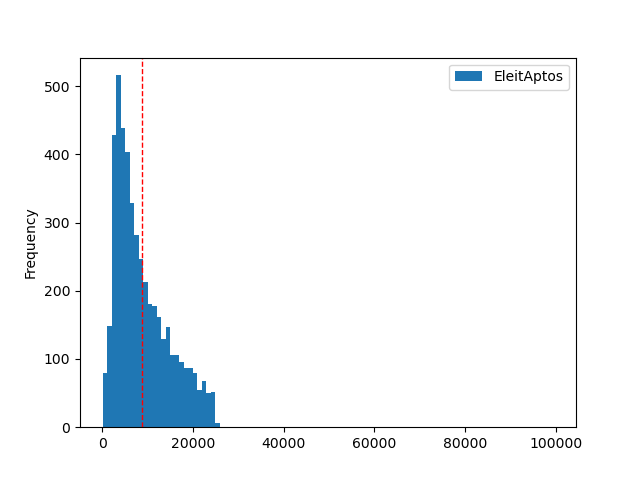

In [117]:
bdt = bd[bd['turno'] == 2]
municipios = bdt.groupby('municipio')['qEleitAptos'].sum().reset_index(name='EleitAptos')

municipios = municipios[municipios['EleitAptos'] <= 25000]
# 5709
municipios.plot.hist(column='EleitAptos', bins=100)
plt.axvline(municipios['EleitAptos'].mean(), color='r', linestyle='dashed', linewidth=1)
printmd(f' ###O gráfico de distribuição do número de cidades por **eleitores aptos a votarem**, mostra um maior número de cidades com 23 mil votantes (segundo o TSE o número de eleitores habilitados é de 156.451.836 e o número da população brasileira é de 215.350.000, ou seja, 72.65% está apto para as eleições 2022, portanto um município com a população eleitoral de 23 mil eleitores aptos, representa aproximadamente 32 mil habitantes, portanto analisando cidades entre 10 mil e 30 mil comparecimentos, que representariam cidades de 20 a 50 mil habitantes aproximadamente.')

In [118]:
municipios = bd.groupby('municipio')['qComparecimento'].sum()
municipio_comparecimento = municipios[(municipios > 0) & (municipios < 25000)]
#bd[bd['municipio'].isin(municipio_comparecimento)].groupby('modelUrna')['qComparecimento'].sum().reset_index(name='qtd')

municipio_modelos_urna = bd[bd['municipio'].isin(municipio_comparecimento.index)].groupby('modelUrna')['modelUrna'].count()
municipio_total_votos = bd[bd['municipio'].isin(municipio_comparecimento.index)].groupby('modelUrna')[['vPresA22', 'vPresB13', 'qComparecimento']].sum()

#calcula o percentual de votos de cada presidente de acoardo com o model de urna
municipio_total_votos['Perc Bolsonaro'] = municipio_total_votos['vPresA22'].div(municipio_total_votos['qComparecimento']).multiply(100).round(2)
municipio_total_votos['Perc Lula'] = municipio_total_votos['vPresB13'].div(municipio_total_votos['qComparecimento']).multiply(100).round(2)

# calcula os votos a favor do candidato Lula
municipio_total_votos['Perc Votos Favor Lula'] = municipio_total_votos['Perc Lula'].div(municipio_total_votos['Perc Bolsonaro']).sub(1).multiply(100).round(2)

tabela_municipio_modelos_urna = pd.concat([municipio_modelos_urna, municipio_total_votos], axis=1)
# modelos_urna.rename(columns={'modelUrna': 'Qtd Urnas', 'vPresTotal': 'Perc Total Votos'}, inplace=True) # renomeia as colunas
tabela_municipio_modelos_urna

,modelUrna,vPresA22,vPresB13,qComparecimento,Perc Bolsonaro,Perc Lula,Perc Votos Favor Lula
modelUrna,,,,,,,
UE2009,24267,2325020,3003380,5701420,40.78,52.68,29.18
UE2010,53918,4580867,7035773,12451215,36.79,56.51,53.60
UE2011,17148,1465851,2178151,3919468,37.40,55.57,48.58
UE2013,16659,1413262,2146483,3827906,36.92,56.07,51.87
UE2015,42696,3841170,5389004,9893933,38.82,54.47,40.31
UE2020,31804,2812548,4068807,7423497,37.89,54.81,44.66


Constata-se que a distribuição dos modelos de urnas nessas cidades ainda é similar aos planos Regional e Estadual.

Mesmo em cidades pequenas/médias, onde existe menos heterogeneidade e geralmente a maioria dos habitantes do município compartilham de visões políticas muito semelhantes devido ao meio comum que se encontram, **é um fato nítido que as urnas do grupo "UE2020" continuam apresentando o menor percentual favorável ao candidato Lula quando comparado com as urnas do grupo "Não-UE2020", onde o percentual de votos a favor do candidato Lula varia entre 32% e 54%, muito acima do grupo "UE2020" que foi de 17.5%**.

Portando indaga-se às autoridades eleitorais, **como pode em todos as localidades comparadas, Região, Estado, Cidades (pequenas/médias de ideologia política mais homogênea) TODAS as Urnas Eletrônicas do Modelo "Não-UE2020" tem um percentual Bastante SUPERIOR de VANTAGEM de VOTOS ao candidato Lula, nesse caso chegando a até 3.1 vezes maior que as urnas de model "UE2020"?**

Ora, espera-se que uma moeda lançada milhares de vezes dê em média, aproximadamente 50% de Cara ou Coroa, mas se esta moeda, após milhões de lançamentos der um mínimo percentual de 0.1% de diferença (49.95% x 50.05%) já é considerada viciada, então o que dizer de um grupo de Urnas, que nos mesmos grupos analisados, sempre favorecem muito mais um canditado que o outro?

## Estatísticas da Votação e Estados com Segundo Turno para Governador

(em desenvolvimento)